# **Evaluation**


In [17]:
# import dependencies and set filepaths to load files

import os
from pathlib import Path
import time
import numpy as np
import faiss
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv, find_dotenv

# load .env file from project dir
load_dotenv(find_dotenv())

FAISS_INDEX_PATH = os.getenv("FAISS_INDEX_PATH")
index = faiss.read_index(FAISS_INDEX_PATH)

PROJECT_ROOT = Path().resolve().parent

FEATURES_PATH = PROJECT_ROOT / "data" / "processed" / "features.npy"
features = np.load(FEATURES_PATH, allow_pickle=True)

TRACK_IDS_PATH = PROJECT_ROOT / "data" / "processed" / "track_ids.npy"
track_ids = np.load(TRACK_IDS_PATH, allow_pickle=True)

DESCRIPTION_TEXTS_PATH = Path("/Users/maanvic123/Downloads/description_texts.npy")
description_texts = np.load(DESCRIPTION_TEXTS_PATH, allow_pickle=True)

In [5]:
# helper function to embed text using OpenAI model
import openai 

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
client = openai.OpenAI(api_key=OPENAI_API_KEY)

def embed_text(text: str):
    resp = client.embeddings.create(
        model="text-embedding-3-small",
        input=[text]
    )
    emb = np.array(resp.data[0].embedding, dtype=np.float32)
    emb = emb / (np.linalg.norm(emb) + 1e-12)
    return emb.reshape(1, -1)

In [6]:
# spotify helper functions - get access token, call spotify API to get track metadata
import requests
import spotipy

SPOTIFY_CLIENT_ID = os.getenv("SPOTIFY_CLIENT_ID")
SPOTIFY_CLIENT_SECRET = os.getenv("SPOTIFY_CLIENT_SECRET")


# check, update, cache spotify access token
_spotify_token = {"access_token" : None, "expires_at" : 0}
def get_spotify_token():
    now = time.time()
    # token already exists
    if _spotify_token["access_token"] and _spotify_token["expires_at"] > now + 10:
        return _spotify_token["access_token"]
    # get and cache new access token if current token not valid
    url = "https://accounts.spotify.com/api/token"
    data = {
        "grant_type" : "client_credentials",
        "client_id" : SPOTIFY_CLIENT_ID,
        "client_secret" : SPOTIFY_CLIENT_SECRET
    }
    headers = {"Content-Type" : "application/x-www-form-urlencoded"}
    resp = requests.post(url, data=data, headers=headers)
    resp.raise_for_status()
    jd = resp.json()
    # store token and expiration time
    _spotify_token["access_token"] = jd["access_token"]
    _spotify_token["expires_at"] = now + jd.get("expires_in", 3600)
    # return spotify access token
    return _spotify_token["access_token"]


# call spotify API to get track metadata given track ID
def get_track_metadata(track_id: str):
    url = f"https://api.spotify.com/v1/tracks/{track_id}"
    headers = {"Authorization": f"Bearer {get_spotify_token()}"}
    resp = requests.get(url, headers=headers)
    resp.raise_for_status()
    data = resp.json()

    name = data.get("name")
    artists = ", ".join(a["name"] for a in data.get("artists", []))

    return {
        "track_id": track_id,
        "name": name,
        "artists": artists,
    }


In [7]:
# helper function to search FAISS index given user query and return top 3 recommended songs

def query_faiss_from_text(text: str, k=3):
    qvec = embed_text(text)         # embed user input with OpenAI API call
    D, I = index.search(qvec, 3)    # search FAISS index for top 3 similar song vectors

    # extract track IDs and confidence score returned by FAISS search
    ranked_track_ids = [track_ids[idx] for idx in I[0]]
    ranked_scores = [float(s) for s in D[0]]

    # get metadata for each track from Spotify API
    results = []
    for tid, score in zip(ranked_track_ids, ranked_scores):
        metadata = get_track_metadata(tid)
        metadata["score"] = float(score)
        results.append(metadata)

    # {query:text, results:[{track1id, track1name, track1artists}, {track2}, {track3}]
    return {"query": text, "results": results}

In [8]:
# run example queries and print results

queries = [
  "motivational chill study",
  "happy christmas",
  "roadtrip singalong",
  "rainy day",
  "energetic evening run",
  "calm indie acoustic",
  "classical piano instrumental"
]

results = []

# for each query, print top 3 results (track IDs)
for q in queries:
  res = query_faiss_from_text(q, k=3)
  results.append(res)

  # print results
  print(f"\nquery: {q}")
    
  # each track entry is dict -- {"track_id": ..., "name": ..., "artists": ..., "score": ...}
  for item in res["results"]:
      name = item["name"]
      artists = item["artists"]
      score = item["score"]
      print(f"{name} — {artists} (score = {score:.2f})")


query: motivational chill study
chillfool chillusion — yeyts. (score = 0.47)
Chill Massage Music — Study Music & Sounds, Piano for Studying, Study Music And Piano Music (score = 0.47)
chill — n o r m a l (score = 0.44)

query: happy christmas
Wish You a Merry Christmas / Ahameric Temple (feat. Ray I, Inner Circle) — Jacob Miller, Ray I, Inner Circle (score = 0.53)
MERRY XMAS (FROHE WEIHNACHT) — Christin Stark (score = 0.51)
Christmas Just Ain't Christmas — Idina Menzel (score = 0.50)

query: roadtrip singalong
Physical (Singalong Version) — Glee Club Singers (score = 0.52)
One (Singalong Version) — Glee Club Singers (score = 0.52)
Hello (Singalong Version) — Glee Club Singers (score = 0.51)

query: rainy day
rainy day — aekasora (score = 0.56)
Rainy Day — Rain Sounds (score = 0.55)
Lazy Rainy Days — Piano Peace (score = 0.54)

query: energetic evening run
Night Runners — EDDIE, Voicians (score = 0.48)
Run Run Run — Phoenix (score = 0.45)
Running With The Night — Lionel Richie (score =

In [22]:
# baseline (random sampling) comparison

import random
import numpy as np

def random_baseline_for_text(text, k=3):
    # randomly sample tracks as "recommendations" for input text
    random_seed = random.Random(2025)
    ids = random_seed.sample(range(len(track_ids)), k)  # get k random indices
    
    # embed input query text
    vec_q = embed_text(text).astype(np.float32).reshape(-1)
    vec_q = vec_q / (np.linalg.norm(vec_q) + 1e-12)

    # embed randomly sampled songs using precomputed description texts
    results = []
    for i in ids:
        # get description text of track by index
        desc = description_texts[i]

        # embed track description with L2 normalization
        vec_i = embed_text(desc).astype(np.float32).reshape(-1)
        vec_i = vec_i / (np.linalg.norm(vec_i) + 1e-12)

        # compute cosine similarity and distance from mean between query and track
        cos_sim = float(np.dot(vec_q, vec_i))
        cos_dist = 1.0 - cos_sim

        # get spotify metadata for track
        tid = track_ids[i]
        metadata = get_track_metadata(tid)

        results.append({
            "index":i,
            "track_id":tid,
            "name":metadata.get("name"),
            "artists":metadata.get("artists"),
            "score":cos_dist
        })
    
    return results


# compare FAISS vs. baseline results for 1 example query
q = "motivational chill study"
faiss_result = query_faiss_from_text(q, k=3)
rand_result = random_baseline_for_text(q, k=3)

print("query:", q)

# compute and print mean distance results
faiss_mean_score = np.mean([item["score"] for item in faiss_result["results"]])
rand_mean_score = np.mean([item["score"] for item in rand_result])
print("FAISS mean distance:", faiss_mean_score)
print("random baseline mean distance:", rand_mean_score)

# print track names for comprison
print(f"\nrandom song recommendations:")
for item in rand_result:
    name = item["name"]
    artists = item["artists"]
    score = item["score"]
    print(f"{name} — {artists} (distance = {score:.2f})")

print(f"\nFAISS song recommendations:")
for item in faiss_result["results"]:
    name = item["name"]
    artists = item["artists"]
    score = item["score"]
    print(f"{name} — {artists} (distance = {score:.2f})")

query: motivational chill study
FAISS mean distance: 0.46000386277834576
random baseline mean distance: 0.8602317745486895

random song recommendations:
Happy Accidents — Outwild, Inukshuk (distance = 0.83)
Haru Haru — BIGBANG (distance = 0.88)
Temblando — Aníbal Troilo (distance = 0.87)

FAISS song recommendations:
chillfool chillusion — yeyts. (distance = 0.47)
Chill Massage Music — Study Music & Sounds, Piano for Studying, Study Music And Piano Music (distance = 0.47)
chill — n o r m a l (distance = 0.44)


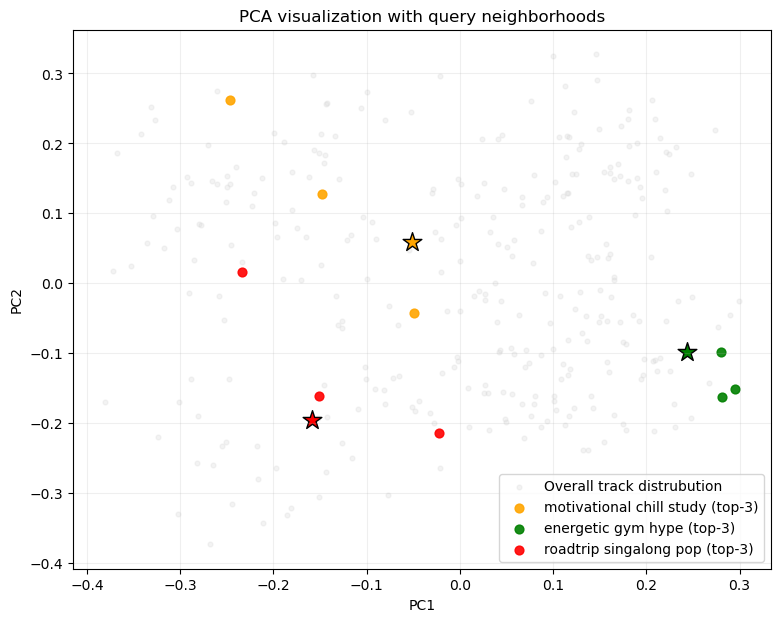

In [29]:
# PCA (principal component analysis) visualization of query vector + recommended tracks by FAISS search

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def pca_viz_multiple_queries(queries, k=10, background_n=300, seed=42):

    # colors for the queries
    colors = ["orange", "green", "red", "blue", "purple"]

    rng = np.random.default_rng(seed)

    # 1) Sample background tracks
    background_indices = rng.choice(len(track_ids), size=background_n, replace=False)

    # 2) Compute embeddings for background tracks
    bg_vecs = []
    for i in background_indices:
        desc = description_texts[i]
        vec = embed_text(desc).astype(np.float32).reshape(-1)
        vec = vec / (np.linalg.norm(vec) + 1e-12)
        bg_vecs.append(vec)

    bg_vecs = np.vstack(bg_vecs)

    # store embeddings of all queries+neighbors to PCA them together
    all_vecs = [bg_vecs]     # start with background
    query_and_neighbors_coords = {}   # to store coords for plotting later

    # 3) For each query: embed query, get top-k, embed neighbors
    for qi, q in enumerate(queries):
        q_color = colors[qi % len(colors)]

        # --- embed query ---
        qvec = embed_text(q).astype(np.float32).reshape(-1)
        qvec = qvec / (np.linalg.norm(qvec) + 1e-12)

        # --- get FAISS top-k ---
        faiss_res = query_faiss_from_text(q, k=k)
        neighbor_indices = []

        for item in faiss_res["results"]:
            tid = item["track_id"]
            # convert tid -> numeric index in track_ids
            idx = np.where(track_ids == tid)[0][0]
            neighbor_indices.append(idx)

        # --- embed top-k neighbors ---
        neighbor_vecs = []
        for idx in neighbor_indices:
            desc = description_texts[idx]
            vec = embed_text(desc).astype(np.float32).reshape(-1)
            vec = vec / (np.linalg.norm(vec) + 1e-12)
            neighbor_vecs.append(vec)

        neighbor_vecs = np.vstack(neighbor_vecs)

        # store for later plotting
        all_vecs.append(neighbor_vecs)
        all_vecs.append(qvec.reshape(1, -1))

        query_and_neighbors_coords[q] = {
            "color": q_color,
            "qvec": qvec,
            "neighbors": neighbor_vecs
        }

    # 4) Run PCA on all embeddings together
    all_matrix = np.vstack(all_vecs)
    pca = PCA(n_components=2)
    all_coords = pca.fit_transform(all_matrix)

    # 5) Split coordinates back into groups
    offset = 0

    bg_coords = all_coords[offset : offset + background_n]
    offset += background_n

    for q in queries:
        q_color = query_and_neighbors_coords[q]["color"]
        nb_vecs = query_and_neighbors_coords[q]["neighbors"]
        nb_count = nb_vecs.shape[0]

        # top-k neighbors coords
        nb_coords = all_coords[offset : offset + nb_count]
        offset += nb_count

        # query point coords (single)
        q_coord = all_coords[offset]
        offset += 1

        query_and_neighbors_coords[q]["coords_neighbors"] = nb_coords
        query_and_neighbors_coords[q]["coords_query"] = q_coord

    # 6) Plot everything
    plt.figure(figsize=(9,7))
    plt.scatter(bg_coords[:,0], bg_coords[:,1], 
                s=12, alpha=0.25, color="lightgray", label="Overall track distrubution")

    # plot query neighborhoods
    for q in queries:
        q_color = query_and_neighbors_coords[q]["color"]
        nb_coords = query_and_neighbors_coords[q]["coords_neighbors"]
        q_coord  = query_and_neighbors_coords[q]["coords_query"]

        plt.scatter(nb_coords[:,0], nb_coords[:,1], 
                    s=40, alpha=0.9, color=q_color, label=f"{q} (top-{k})")

        plt.scatter(q_coord[0], q_coord[1],
                    s=200, marker="*", edgecolor="black", color=q_color)

    plt.title("PCA visualization with query neighborhoods")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(alpha=0.2)
    plt.legend()
    plt.show()


queries_to_plot = [
    "motivational chill study",
    "energetic gym hype",
    "roadtrip singalong pop"
]

pca_viz_multiple_queries(queries_to_plot, k=3)

# **Discussion of Results**

**Random baseline comparison**
- To evaluate the quality of FAISS search, I compared the top 3 FAISS results to a random baseline for the query "motivational chill study".
- FAISS mean distance: 0.46 vs. random baseline mean distance: 0.86 -- lower distances signify closer semantic match to the query, so we can see FAISS performs much better than the random baseline.
- Qualitatively, if we look at the randomly recommended songs, we can see that the songs don't reflect the vibe of the input query, whereas the FAISS recommendations do.

**PCA visualization**
- PCA (Principal Component Analysis) reduces the original 1536-dimension embedding space into 2 dimensions for easier visualization of structure. Points that are closer together in the PCA plot have similar semantic embeddings.
- Gray dots represent the overall distribution of songs in the embedding space
- Each query vector ("motivational chill study", "energetic gym hype", "roadtrip singalong pop") is represented by a star, and its top 3 FAISS neighbors (recommended songs) are plotted in the same color. For the most part, the recommended song vectors are close to the query vector, demonstrating how the embedding model captures strong semantic differences between the three different prompts. This shows that FAISS retrieves songs positioned near the query in the underlying embedding space, reinforcing the correctness of the model.

**Limitations**
- Overreliance on song title -- song title is part of textual description of song that is embedded, and most recommended song titles contain words from the query itself. Model may focus too much on title similarity to query vector instead of the rest of the textual description that comes from numerical audio features.